## What Skills Do You Need to Transition from Data Analyst to Data Scientist?

This section explores the skills needed to transition roles using global 2024 job postings. We will cover:

- The average number of skills required for Data Analyst and Data Scientist roles.
- Gap analysis comparing the skill sets of Data Analysts and Data Scientists.
- The most impactful skills on salary within these roles.

### Import Libraries

In [19]:
from pathlib import Path
import ast

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.ensemble import RandomForestRegressor
import shap

### Load Cleaned Dataset

In [2]:
df = pd.read_pickle(Path.cwd().parents[1] / 'Raw_Data' / 'df_Final_2.pkl')

### Filter Dataset for 2024 Job Postings with Skills

To focus on the latest trends, we filter for job postings from 2024 that include non-null skill data.

In [23]:
df_2024 = df[
    df['job_posted_date'].astype(str).str.startswith('2024')
    & df['job_skills'].notna()
].copy()

### Number of Skills vs Number of Job Postings (2024)

Here we analyze how many skills are typically required for Data Analyst and Data Scientist roles. Understanding this helps to grasp the complexity and expectations for transitioning between these roles.

In [25]:
roles = ["Data Scientist", "Data Analyst"]
df_filtered = df_2024[(df_2024["job_title_short"].isin(roles))].copy()

df_filtered['num_skills'] = df_filtered['job_skills'].apply(len)

grouped = df_filtered.groupby(["job_title_short", "num_skills"]).size().reset_index(name="num_postings")
mean_skills = df_filtered.groupby("job_title_short")["num_skills"].mean().round(0).astype(int)

# Plot
fig = px.scatter(
    grouped,
    x='num_skills',
    y='num_postings',
    color='job_title_short',
    title='Number of Skills vs Number of Job Postings (2024)',
    labels={
        'num_skills": "Number of Skills',
        'num_postings": "Number of Job Postings',
        'job_title_short": "Job Title'
    },
    template='plotly_white',
    color_discrete_map={
        'Data Scientist': 'steelblue',
        'Data Analyst': 'lightskyblue'
    }
)

# Uniform marker size
fig.update_traces(marker=dict(size=10, opacity=0.8))

# Add vertical lines for averages
for role in roles:
    avg = mean_skills[role]
    fig.add_vline(
        x=avg,
        line=dict(color="gray", dash="dash"),
        layer="below"
    )

# Add combined annotation box near the dotted lines (right side)
avg_text = (
    f'Avg number of skills<br>'
    f"Data Analyst: {mean_skills['Data Analyst']}<br>"
    f"Data Scientist: {mean_skills['Data Scientist']}"
)
fig.add_annotation(
    x=max(mean_skills) + 0.7,
    y=grouped["num_postings"].max(),
    text=avg_text,
    showarrow=False,
    align="left",
    bgcolor="white",
    bordercolor="gray",
    borderwidth=1,
    font=dict(color="black", size=12)
)

# Clean up x-axis ticks
fig.update_layout(
    width=850,
    height=500,
    legend_title_text="Job Title",
    xaxis=dict(
        tickmode="array",
        tickvals=[0, 5, 10],
        title="Number of Skills per Job Posting"
    ),
    yaxis=dict(
        title="Number of Job Postings"
    )
)

fig.show()

Average number of skills needed to land Data Analyst Role is 4 when for Data Scientist the number is 6. Now we can find the most in-demand Data Analyst skills that could be useful for transition to Data Scientist Role and skills that is needed to get additionally. 

### Skill Requirements for Transition: Skills You Should Have vs. Skills to Learn

We identify the top-4 most in-demand Data Analyst skills and the top-6 Data Scientist skills in 2024. By comparing these sets, we reveal which skills a job seeker should develop further and which new skills are needed to successfully transition into a Data Scientist role.

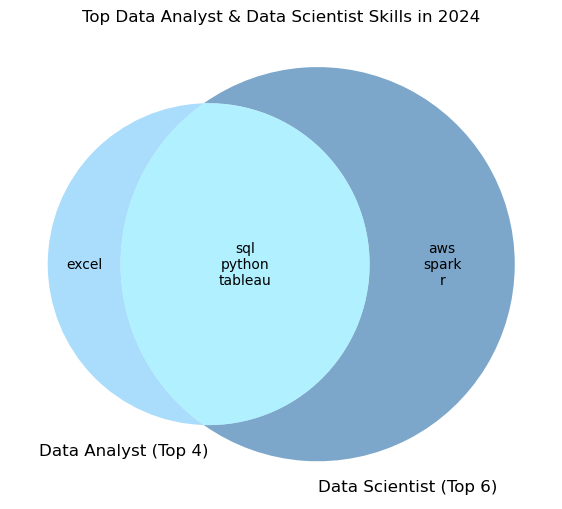

In [5]:
# Data Analyst: Top 4 skills in 2024
skills_da = df_2024[df_2024['job_title_short'] == 'Data Analyst']['job_skills']
skill_counts_da = {}
for skills in skills_da:
    if isinstance(skills, list):
        for skill in skills:
            skill_counts_da[skill] = skill_counts_da.get(skill, 0) + 1
top4_da = sorted(skill_counts_da, key=skill_counts_da.get, reverse=True)[:4]

# Data Scientist: Top 6 skills in 2024
skills_ds = df_2024[df_2024['job_title_short'] == 'Data Scientist']['job_skills']
skill_counts_ds = {}
for skills in skills_ds:
    if isinstance(skills, list):
        for skill in skills:
            skill_counts_ds[skill] = skill_counts_ds.get(skill, 0) + 1
top6_ds = sorted(skill_counts_ds, key=skill_counts_ds.get, reverse=True)[:6]

# Convert to sets for Venn diagram
set_da = set(top4_da)
set_ds = set(top6_ds)

# Plot Venn diagram
plt.figure(figsize=(7,7))
venn = venn2(
    [set_da, set_ds],
    set_labels=('Data Analyst (Top 4)', 'Data Scientist (Top 6)'),
    set_colors=('lightskyblue', 'steelblue'),  # custom colors
    alpha=0.7  # transparency
)

# Annotate each section with skill names
if venn.get_label_by_id('10'):
    venn.get_label_by_id('10').set_text('\n'.join(set_da - set_ds))
if venn.get_label_by_id('01'):
    venn.get_label_by_id('01').set_text('\n'.join(set_ds - set_da))
if venn.get_label_by_id('11'):
    venn.get_label_by_id('11').set_text('\n'.join(set_da & set_ds))

plt.title('Top Data Analyst & Data Scientist Skills in 2024')
plt.show()

The Venn diagram illustrates the overlap and differences between the top skills for Data Analysts and Data Scientists:

- SQL, Python, and Tableau are essential for both roles.
- Excel, fundamental for Data Analysts, is less important for Data Scientists, so no need develop this skill when you are looking for the transition.
- Instead focus on learning AWS, Spart and R that'll help to sucseed Data Scientist role requirement.

### Analyzing the Impact of Skills on Salary

To quantify how individual skills influence salary for Data Scientist roles, we perform the following:

1. Prepare the dataset by filtering roles and one-hot encoding the top skills.
2. Train a tree-based regression model (Random Forest) to estimate salaries.
3. Use SHAP values for interpretable feature importance.

In [26]:
df_ds = df_2024[df_2024['job_title_short'] == 'Data Scientist'].copy()

top10_skills = (
    pd.Series([skill for skills in df_ds['job_skills'] if skills for skill in skills])
    .value_counts()
    .head(10)
    .index
)

# One-hot encode top 10 skills
for skill in top10_skills:
    df_ds[skill] = df_ds['job_skills'].apply(lambda skills: int(skill in skills))

# Features & target
X = df_ds[top10_skills]
y = df_ds['salary_month_avg_eur']

df_ds.head(5)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,...,python,sql,r,tableau,spark,aws,sas,azure,tensorflow,pytorch
1,Data Scientist,Data Scientist III (50% REMOTE) Jobs,"Huntsville, AL",via Clearance Jobs,Contractor,False,Georgia,2024-01-01,False,False,...,1,0,0,0,0,1,0,0,1,1
2,Data Scientist,Principal Data Scientist,"Palmyra, PA",via Ladders,Full-time,False,"New York, United States",2024-01-01,False,False,...,0,0,0,0,0,0,0,0,0,0
7,Data Scientist,Data Science,United States,via BeBee,Full-time,False,"Illinois, United States",2024-01-01,False,False,...,0,1,0,1,0,0,1,0,0,0
12,Data Scientist,Principal Data Scientist,Anywhere,via LinkedIn,Full-time,True,Sudan,2024-01-01,False,False,...,0,0,0,0,0,1,0,0,0,0
15,Data Scientist,GIS and Data Analysis Specialist,Anywhere,via Get.It,Full-time,True,"California, United States",2024-01-01,False,True,...,1,1,1,1,0,1,0,0,0,0


We train a Random Forest Regressor on the one-hot encoded skills and compute SHAP values to explain the model predictions.

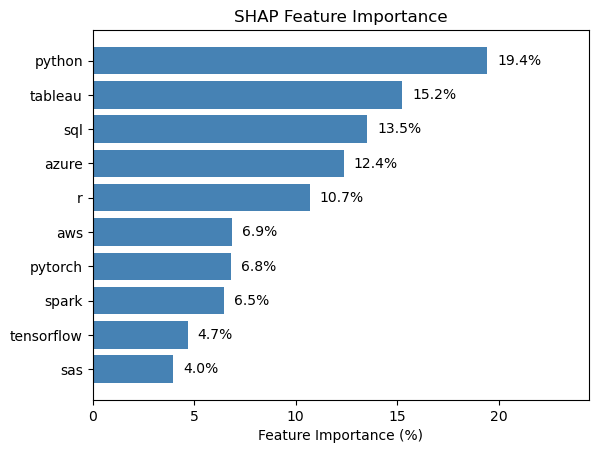

In [17]:
model = RandomForestRegressor(random_state=42).fit(X, y)
explainer = shap.TreeExplainer(model)
sv = explainer(X)

means = np.abs(sv.values).mean(0)
perc = means / means.sum() * 100
idx = np.argsort(means)[::-1]

plt.barh(np.array(X.columns)[idx], perc[idx], color="steelblue")
plt.gca().invert_yaxis()
plt.xlim(0, perc.max() + 5)

for i, v in enumerate(perc[idx]):
    plt.text(v + 0.5, i, f"{v:.1f}%", va='center')
plt.xlabel("Feature Importance (%)")
plt.title("SHAP Feature Importance")
plt.show()

SHAP feature importance for the Random Forest Regressor model predicting salaries shows skill’s contribution to the model’s predictions, expressed as a percentage of total importance. 
- Python (19.4%) has the largest impact on salary predictions.
- Tableau, SQL, and Azure follow as other high-impact skills.
- Skills like SAS and TensorFlow contribute less, but still play a role.

### Summary:

This analysis explored the skill requirements for transitioning from Data Analyst to Data Scientist roles using 2024 global job postings.

- On average, Data Scientists require about 6 skills per job posting, while Data Analysts require about 4.
- The common top skills for Data Analysts and Data Scientists are SQL, Python and Tableau. These skills are also the most impactful on salary. 
- To transition successfully, Data Analysts should close the skill gap with Data Scientist requirements, focusing on learning AWS, Spark, and R.
  
The next notebook will leverage this list of impactful skills to build predictive models for salary estimation, aiding individuals in understanding the value of specific skills in the job market.